In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
%matplotlib inline

# Logisitic Regression

Inspite of its name Logisitic Regression is used in classification problems. To illustrate what we mean by classification, we will randomly generate data drawn from two different normal distrubutitions and label them Class 1 or Class 2 dependening upon which distrabution it was drawn from.

In [5]:
#Make test data
def make_cluster( x, y, var, num=30, label=0):
    xt = np.random.normal(x, var, num)
    yt = np.random.normal(y, var, num)

    return np.stack((yt,xt, label*np.ones((num))),axis=1)

num=60
x1=make_cluster(7,2,0.7,num,0)
x2=make_cluster(8,7,0.8,num,1)

df = pd.DataFrame( data=np.concatenate((x1,x2)),columns=['x','y','lbl'] )

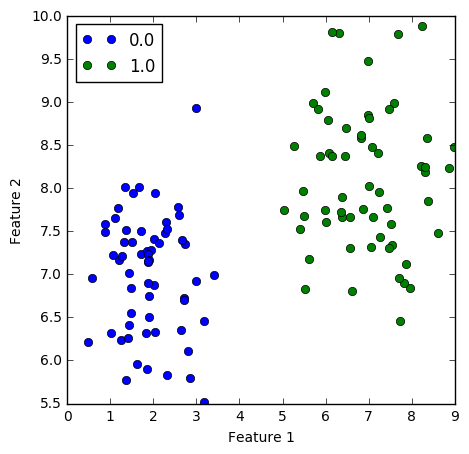

In [6]:
def plot_groups( df, label='lbl' ):
    fig = plt.figure(figsize=(5,5))
    for grp in df.groupby(label):
        plt.plot(grp[1].x,grp[1].y,'o',label=grp[0])
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.legend(loc=2)
    return fig
f=plot_groups(df)

To our eye this looks like a simple classification problem: draw a line down the center and if a point is on the left side of the line call it class 1, if its on the right side call it class two. But how do we teach a computer to do this?

## Some Background
<p>
Unlike in linear regression where our goal was to find a hypothsis function that passed through our data, here we could like to find a  function z that will bisect the blue and green clusters. 
</p>
$$z_{seperating} = w_{1} \cdot x_{1} + w_{2} \cdot x_{2} ... + w_{n}\cdot x_{n}$$ 

A bysecting line (in 2D or hyperplane in higher order of features) will allow use to define a new hypothesis function that will classify points lying 'above' the bisecting hypothsis function as one class and those below as another.  When $h(z) \geq 0 = 1$ representing Class 1 and when $h(z) < 0 = 0$ representing Class 2.
</p>

<p>
We thus need a function that will transform the range of the linear function z into a value within the range [0,1] descrbing the probability our algrgrothm ascbribes to given point with features F belonging to class 1. A common choice is the Logisitc Function:
$$h(z) = \frac{1}{1+e^{-z}}$$
ploted below for values of z between -10 and 10.
</p>

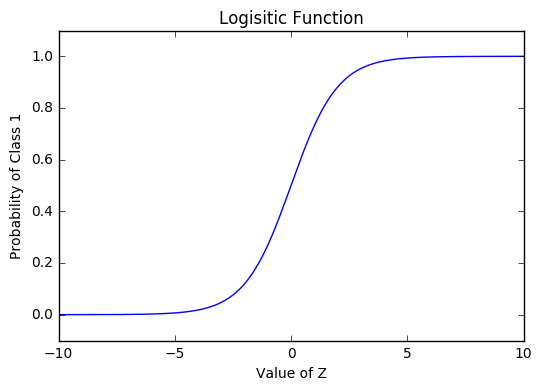

In [7]:
def logisitic(x): return 1./(1+np.exp(-x))

x=np.linspace(-10,10,1000)
plt.plot(x,logisitic(x))
plt.ylim([-.1,1.1])
plt.title("Logisitic Function")
plt.xlabel('Value of Z'); plt.ylabel('Probability of Class 1')
plt.show()

The good news is that we have a resoanble hypothesis function. The bad news is that we do not yet know the optimal weights w that we will need to seperate our classes. We will just have to make the computer find the optimal weights for us!

The loss function we previously defined for linear regression $J(\vec{w}) = \sum ( h(\vec{w}|\vec{X}) - y)^{2}$ will not work here. (Consider what would happen to our error term $J(\vec{w})$ if $h(\vec{w}|\vec{X})$ predicted a very large or very small value of z when in fact y can only take on the values Class or Class 2)

Instead we will use a 'Log-Loss' Function:

$$ J(\vec{w}) = y \cdot log| h(\vec{w}|\vec{X})| + (1-y)\cdot log| 1-h(\vec{w}|\vec{X})| $$ 
I think about this as two different loss functions combined into one. When  the true value y should be 1 the second term drops to zero and we are left with $ J(\vec{w}, y=1) = log| h(\vec{w}|\vec{X})| $. Conversley when the trure value y is zero, the first term drops out leaving us with $ J(\vec{w}) = log| 1-h(\vec{w}|\vec{X})| $. To see why this works lets plot out the loss functions below for different values of z:

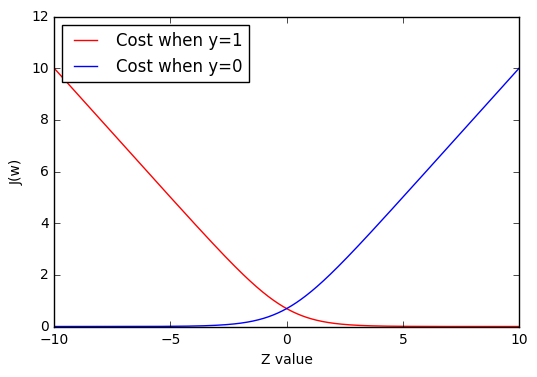

In [179]:
x=np.linspace(-10,10,1000)
plt.plot(x, -np.log(1/(1+np.exp(-x))),'r',label='Cost when y=1')
plt.plot(x, -np.log(1-(1/(1+np.exp(-x)))),'b',label='Cost when y=0')
plt.legend(loc=2); plt.xlabel('Z value'); plt.ylabel('J(w)')
plt.show()

We are now left with a convex optimization problem that we know how to optimize via gradient descent! The derviative of J(w) is alittle messy to derive but simple in form:

$$\frac{\delta J}{\delta w_{i}} = x_{i} \cdot (h(\vec{w}|\vec{X})-y) $$


Now we can just tack on some regularization terms to keep our model from overfitting:

Cost function with L1 (Lasso) regularization:
$ J(w) = J(w) + \alpha\cdot\sum |w_{i}|$   

Cost function with L2 (Ridge) regularization:
$ J(w) = J(w) + \alpha\cdot\sum w_{i}^{2}$  

And we are good to go! Lets try it out with sklearn!

In [8]:
from sklearn import linear_model, model_selection

In [9]:
df_train, df_test = model_selection.train_test_split(df, test_size=.2, stratify=df.lbl)

In [10]:
L1 = linear_model.LogisticRegression(penalty='l1', C=1.0)
L1.fit(df_train[['x','y']],df_train['lbl'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
L1.score(df_test[['x','y']],df_test['lbl'])

1.0

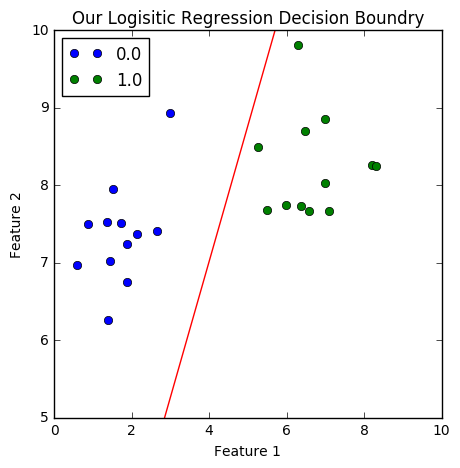

In [13]:
x=np.linspace(-10,10,1000)
plot_groups(df_test)

coef = L1.coef_[0]
intercept = L1.intercept_
db = -(coef[0] * x + intercept[0]) / coef[1]
plt.plot(x, db )
plt.ylim([5,10]); plt.xlim([0,10])
plt.title('Our Logisitic Regression Decision Boundry')
plt.show()